# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00


Импорт необходимых библиотек

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [6]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [7]:
import string
from collections import Counter
from nltk.tokenize import word_tokenize


class TextPreprocessor:
    @staticmethod
    def preprocess_text(text):
        return text.lower().translate(str.maketrans('', '', string.punctuation))




def count_words(texts):
    return Counter(
        word
        for text in texts
        for word in word_tokenize(TextPreprocessor.preprocess_text(text))
    )



def create_vocab(word_counts, counter_threshold=25):
    return {'<unk>', '<bos>', '<eos>', '<pad>'} | {
        word for word, count in word_counts.items() if count > counter_threshold
    }


def create_word_indices(vocab):
    word2ind = {word: i for i, word in enumerate(vocab)}
    ind2word = {i: word for word, i in word2ind.items()}
    return word2ind, ind2word


# Шаг 1: Подсчет слов
word_counts = count_words(tqdm(dataset['train']['text']))

# Шаг 2: Создание словаря
vocab = create_vocab(word_counts)

# Шаг 3: Создание индексов
word2ind, ind2word = create_word_indices(vocab)

print(f'Размер словаря: {len(vocab)}')

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [8]:
class TextTokenizer:
    def __init__(self, word2ind):
        self.word2ind = word2ind
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def tokenize(self, text):
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [self.word2ind.get(word, self.unk_id) for word in word_tokenize(text)]
        tokenized_sentence += [self.eos_id]
        return tokenized_sentence


class WordDataset:
    def __init__(self, sentences, word2ind):
        self.data = sentences
        self.preprocessor = TextPreprocessor()
        self.tokenizer = TextTokenizer(word2ind)

    def __getitem__(self, idx):
        text = self.preprocessor.preprocess_text(self.data[idx]['text'])
        tokenized_sentence = self.tokenizer.tokenize(text)
        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }
        return train_sample

    def __len__(self):
        return len(self.data)


In [9]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from typing import List, Dict


class DataLoaderDecorator:
    def __init__(self, dataset, word2ind, device='cpu'):
        self.dataset = dataset
        self.word2ind = word2ind
        self.pad_id = word2ind['<pad>']
        self.device = device

    def select_random_subset(self, size):
        if size > len(self.dataset):
            raise ValueError("Size larger than dataset")

        idx = np.random.choice(np.arange(len(self.dataset)), size, replace=False)
        idx = [int(i) for i in idx]
        subset = [self.dataset[i] for i in idx]
        return type(self)(subset, self.word2ind, self.device)

    @staticmethod
    def trim_sequences(input_batch: List[Dict[str, List[int]]], max_len=256) -> List[Dict[str, List[int]]]:
        return list(map(lambda sequence: {'text': sequence['text'][:max_len], 'label': sequence['label']}, input_batch))

    @staticmethod
    def pad_sequences(input_batch: List[Dict[str, List[int]]], pad_id, max_len=256) -> List[List[int]]:
        def pad_sequence(sequence: List[int]) -> List[int]:
            return sequence + [pad_id] * (max_len - len(sequence))
        return [pad_sequence(sequence['text']) for sequence in input_batch]

    @staticmethod
    def create_tensors(padded_sequences: List[List[int]], input_batch: List[Dict[str, int]], device) -> Dict[str, torch.Tensor]:
        sequences_tensor = torch.LongTensor(padded_sequences).to(device)
        labels_tensor = torch.LongTensor([x['label'] for x in input_batch]).to(device)
        return {'input_ids': sequences_tensor, 'label': labels_tensor}

    def collate_fn_with_padding(self, input_batch: List[Dict[str, List[int]]], max_len=256) -> Dict[str, torch.Tensor]:
        max_seq_len = min(max([len(x['text']) for x in input_batch]), max_len)
        input_batch = self.trim_sequences(input_batch, max_seq_len)
        padded_sequences = self.pad_sequences(input_batch, self.pad_id, max_seq_len)
        batch_tensors = self.create_tensors(padded_sequences, input_batch, self.device)
        return batch_tensors

    def create_dataloader(self, batch_size=32, shuffle=True, max_len=256):
        return DataLoader(
            self.dataset,
            shuffle=shuffle,
            batch_size=batch_size,
            collate_fn=lambda x: self.collate_fn_with_padding(x, max_len=max_len)
        )


In [10]:
train_dataset = WordDataset(dataset['train'], word2ind)
test_dataset = WordDataset(dataset['test'], word2ind)


train_prep = DataLoaderDecorator(train_dataset, word2ind, device)
eval_prep = DataLoaderDecorator(test_dataset, word2ind, device)
random_eval_prep = eval_prep.select_random_subset(5000)

train_dataloader = train_prep.create_dataloader(batch_size=64, shuffle=True)
eval_dataloader = random_eval_prep.create_dataloader(batch_size=64, shuffle=False)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

### Запуск базовой модели с семинара на новом датасете


In [11]:
import torch
import torch.nn as nn

class Aggregator(nn.Module):
    def forward(self, outputs):
        raise NotImplementedError("Aggregator must implement the forward method")

class MaxAggregator(Aggregator):
    def forward(self, outputs):
        return outputs.max(dim=1)[0]

class MeanAggregator(Aggregator):
    def forward(self, outputs):
        return outputs.mean(dim=1)

In [16]:
class CharLMRNN(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, dropout_value: float,
        num_classes: int = 4,
        aggregator: Aggregator = MaxAggregator()
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_value)

        self.aggregator = aggregator

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = self.aggregator(output)

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction


def choose_aggregator(aggregation_type: str) -> Aggregator:
  if aggregation_type == 'max':
      return MaxAggregator()
  elif aggregation_type == 'mean':
      return MeanAggregator()
  else:
      raise ValueError(f"Unsupported aggregation type: {aggregation_type}")

In [12]:
import torch
import torch.nn as nn
from tqdm import tqdm


class ModelConfiguration:
    def __init__(self, model, device, word2ind):
        self.model = model
        self.device = device
        self.criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
        self.optimizer = torch.optim.Adam(model.parameters())


class ModelEvaluator:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def evaluate(self, eval_dataloader) -> float:
        predictions = []
        targets = []
        with torch.no_grad():
            for batch in eval_dataloader:
                logits = self.model(batch['input_ids'].to(self.device))
                predictions.append(logits.argmax(dim=1))
                targets.append(batch['label'].to(self.device))

        predictions = torch.cat(predictions)
        targets = torch.cat(targets)
        accuracy = (predictions == targets).float().mean().item()

        return accuracy


class ModelTrainer:
    def __init__(self, config: ModelConfiguration, evaluator: ModelEvaluator):
        self.config = config
        self.evaluator = evaluator

    def train(self, train_dataloader, num_epochs, eval_steps, eval_dataloader):
        losses = []
        acc = []

        for epoch in range(num_epochs):
            self.config.model.train()
            epoch_losses = []
            for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
                self.config.optimizer.zero_grad()
                input_ids, labels = batch['input_ids'].to(self.config.device), batch['label'].to(self.config.device)
                logits = self.config.model(input_ids)
                loss = self.config.criterion(logits, labels)
                loss.backward()
                self.config.optimizer.step()

                epoch_losses.append(loss.item())
                if i % eval_steps == 0 and i != 0:
                    accuracy = self.evaluator.evaluate(eval_dataloader)
                    acc.append(accuracy)
                    self.config.model.train()  # Ensure model is back in training mode

            epoch_loss = sum(epoch_losses) / len(epoch_losses)
            losses.append(epoch_loss)

        return losses, acc


class TrainingSessionRunner:
    def __init__(self, trainer: ModelTrainer, choose_aggregator):
        self.trainer = trainer
        self.choose_aggregator = choose_aggregator

    def run_training_sessions(self, train_dataloader, eval_dataloader, num_epochs, eval_steps):
        results = {}
        aggregation_types = ['max', 'mean']
        for aggregation_type in aggregation_types:
            print(f"Starting training for {aggregation_type}")
            self.trainer.config.model.aggregator = self.choose_aggregator(aggregation_type)
            self.trainer.config.model.to(self.trainer.config.device)

            losses, acc = self.trainer.train(train_dataloader, num_epochs, eval_steps, eval_dataloader)

            results[aggregation_type] = {
                'losses': losses,
                'accuracy': acc
            }

        return results


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Создаем экземпляр модели
rnn_model = CharLMRNN(hidden_dim=256, vocab_size=len(vocab), dropout_value=0.1).to(device)

# Конфигурация для модели, включая критерий и оптимизатор
rnn_model_config = ModelConfiguration(rnn_model, device, word2ind)

# Создаем экземпляр для оценки модели
rnn_model_evaluator = ModelEvaluator(rnn_model, device)

# Создаем экземпляр тренера с настройками модели и оценщиком
rnn_trainer = ModelTrainer(rnn_model_config, rnn_model_evaluator)

# Создаем экземпляр для запуска тренировочных сессий
rnn_training_session_runner = TrainingSessionRunner(rnn_trainer, choose_aggregator)

# Запускаем обучение
num_epochs = 5
eval_steps = len(train_dataloader) // 2
results = rnn_training_session_runner.run_training_sessions(train_dataloader, eval_dataloader, num_epochs, eval_steps)

print(results)


Starting training for max


Training epoch 4:: 100%|██████████| 1875/1875 [00:58<00:00, 32.10it/s]


Starting training for mean


Training epoch 4:: 100%|██████████| 1875/1875 [00:58<00:00, 32.09it/s]

{'max': {'losses': [0.40140543719530103, 0.2566012812415759, 0.2174506018360456, 0.19061165632208188, 0.16750875078837077], 'accuracy': [0.8797999620437622, 0.8833999633789062, 0.8941999673843384, 0.8953999876976013, 0.896399974822998, 0.8939999938011169, 0.8983999490737915, 0.8989999890327454, 0.8980000019073486, 0.9016000032424927]}, 'mean': {'losses': [0.34792484314839045, 0.22635849970181782, 0.1922530893901984, 0.16648047189811865, 0.1441814401080211], 'accuracy': [0.8925999999046326, 0.895799994468689, 0.9019999504089355, 0.8965999484062195, 0.9043999910354614, 0.8987999558448792, 0.8973999619483948, 0.9065999984741211, 0.9034000039100647, 0.8985999822616577]}}


In [13]:
import matplotlib.pyplot as plt
import numpy as np


class LossesPlotter():
    def plot(self, losses_type, colors):
        for (name, values), color in zip(losses_type.items(), colors):
            plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)
        plt.title('Losses')
        plt.xlabel("epoch")
        plt.legend()
        plt.show()


class AccuracyPlotter():
    def plot(self, acc_type, colors):
        for (name, values), color in zip(acc_type.items(), colors):
            plt.plot(np.arange(len(acc_type[name])), acc_type[name], color=color, label=name)
           # plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
            print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")
        plt.title('Accuracy')
        plt.xlabel("epoch")
        plt.legend()
        plt.show()


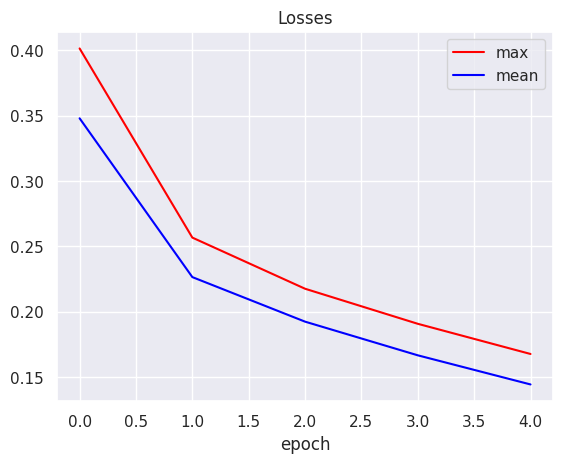

Лучшая accuracy для подхода max: 90.16
Лучшая accuracy для подхода mean: 90.66


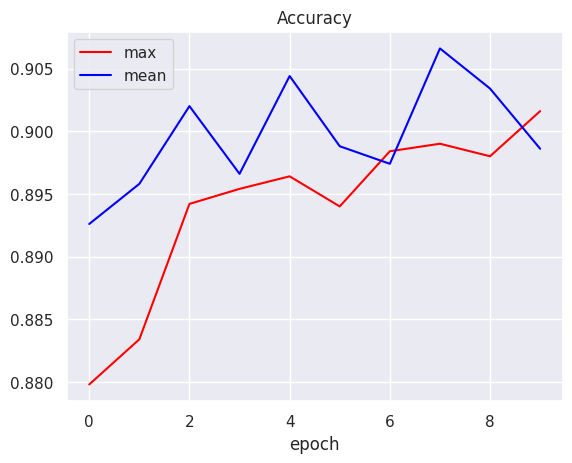

In [ ]:
losses_plotter = LossesPlotter()
accuracy_plotter = AccuracyPlotter()

# Подготовка данных для графиков
losses_type = {'max': results['max']['losses'], 'mean': results['mean']['losses']}
acc_type = {'max': results['max']['accuracy'], 'mean': results['mean']['accuracy']}

# Построение графиков
losses_plotter.plot(losses_type, ['red', 'blue'])
accuracy_plotter.plot(acc_type, ['red', 'blue'])




### Проведение экспериментов по улучшению модели
* Эксперимент 1: увеличение dropout до 0.5



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


rnn_model = CharLMRNN(hidden_dim=256, vocab_size=len(vocab), dropout_value=0.5).to(device)
rnn_model_config = ModelConfiguration(rnn_model, device, word2ind)
rnn_model_evaluator = ModelEvaluator(rnn_model, device)
rnn_trainer = ModelTrainer(rnn_model_config, rnn_model_evaluator)
rnn_training_session_runner = TrainingSessionRunner(rnn_trainer, choose_aggregator)

# Запускаем обучение
num_epochs = 5
eval_steps = len(train_dataloader) // 2
results = rnn_training_session_runner.run_training_sessions(train_dataloader, eval_dataloader, num_epochs, eval_steps)

print(results)



Starting training for max


Training epoch 4:: 100%|██████████| 1875/1875 [00:59<00:00, 31.73it/s]


Starting training for mean


Training epoch 4:: 100%|██████████| 1875/1875 [00:59<00:00, 31.74it/s]

{'max': {'losses': [0.43446068461338677, 0.27539021781484285, 0.2350528669297695, 0.20865542725523312, 0.1871285665154457], 'accuracy': [0.8757999539375305, 0.8759999871253967, 0.8871999979019165, 0.8935999870300293, 0.8991999626159668, 0.902999997138977, 0.892799973487854, 0.8947999477386475, 0.8925999999046326, 0.8965999484062195]}, 'mean': {'losses': [0.3563264180501302, 0.24202316479285557, 0.2080972431619962, 0.1837069283525149, 0.16665230939189593], 'accuracy': [0.8885999917984009, 0.8921999931335449, 0.8987999558448792, 0.8983999490737915, 0.8998000025749207, 0.9031999707221985, 0.894599974155426, 0.8965999484062195, 0.8947999477386475, 0.901199996471405]}}


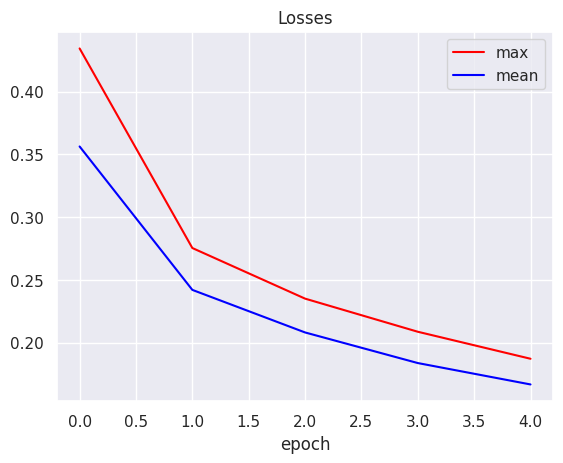

Лучшая accuracy для подхода max: 90.30
Лучшая accuracy для подхода mean: 90.32


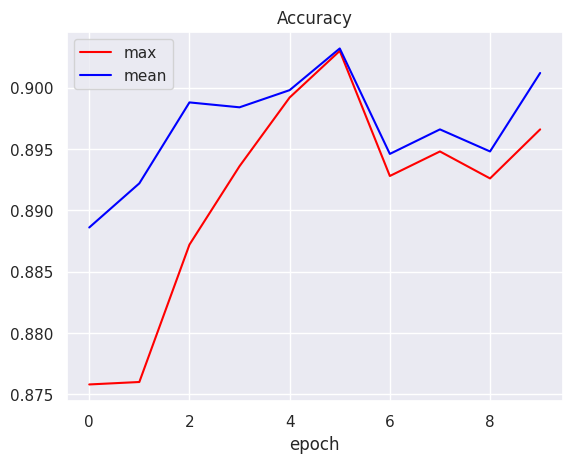

In [ ]:
losses_plotter = LossesPlotter()
accuracy_plotter = AccuracyPlotter()

# Подготовка данных для графиков
losses_type = {'max': results['max']['losses'], 'mean': results['mean']['losses']}
acc_type = {'max': results['max']['accuracy'], 'mean': results['mean']['accuracy']}

# Построение графиков
losses_plotter.plot(losses_type, ['red', 'blue'])
accuracy_plotter.plot(acc_type, ['red', 'blue'])

Эксперимент 2: изменение модели, dropout: 0.5

In [14]:
class CharLMBiLSTM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, dropout_value: float,
        num_classes: int = 4,
        aggregator: Aggregator = MaxAggregator()
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=True)
        # Удваиваем размер скрытого состояния, так как используем двунаправленный LSTM
        self.linear = nn.Linear(hidden_dim * 2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_value)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, (hidden, cell) = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim*2], (hidden, cell)
        output = self.aggregator(output)
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [19]:
lstm_model = CharLMBiLSTM(hidden_dim=256, vocab_size=len(vocab), dropout_value=0.5).to(device)


lstm_model_config = ModelConfiguration(lstm_model, device, word2ind)

lstm_model_evaluator = ModelEvaluator(lstm_model, device)

lstm_trainer = ModelTrainer(lstm_model_config, lstm_model_evaluator)

lstm_training_session_runner = TrainingSessionRunner(lstm_trainer, choose_aggregator)

# Запускаем обучение
num_epochs = 5
eval_steps = len(train_dataloader) // 2
lstm_results = lstm_training_session_runner.run_training_sessions(train_dataloader, eval_dataloader, num_epochs, eval_steps)

print(lstm_results)

Starting training for max


Training epoch 4:: 100%|██████████| 1875/1875 [01:18<00:00, 23.90it/s]


Starting training for mean


Training epoch 4:: 100%|██████████| 1875/1875 [01:19<00:00, 23.72it/s]

{'max': {'losses': [0.3646566513379415, 0.21273898535370828, 0.1536653039271633, 0.11038537009507418, 0.0769668687671423], 'accuracy': [0.8955999612808228, 0.9111999869346619, 0.9023999571800232, 0.9121999740600586, 0.9139999747276306, 0.9143999814987183, 0.9151999950408936, 0.9165999889373779, 0.9161999821662903, 0.915399968624115]}, 'mean': {'losses': [0.19044512086013954, 0.10329455272257328, 0.06643579801917077, 0.0464335646999379, 0.03467650239349653], 'accuracy': [0.9085999727249146, 0.9149999618530273, 0.9061999917030334, 0.9067999720573425, 0.9077999591827393, 0.914199948310852, 0.9053999781608582, 0.9053999781608582, 0.9089999794960022, 0.9070000052452087]}}


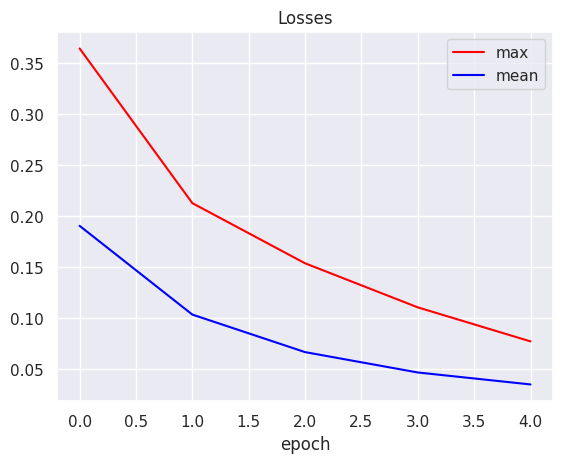

Лучшая accuracy для подхода max: 91.66
Лучшая accuracy для подхода mean: 91.50


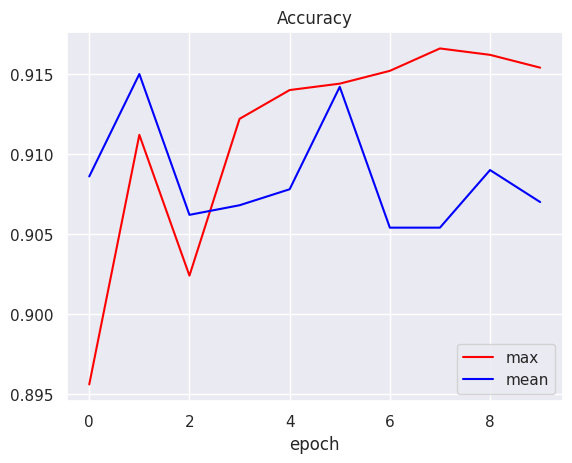

In [20]:
losses_plotter = LossesPlotter()
accuracy_plotter = AccuracyPlotter()

# Подготовка данных для графиков
losses_type = {'max': lstm_results['max']['losses'], 'mean': lstm_results['mean']['losses']}
acc_type = {'max': lstm_results['max']['accuracy'], 'mean': lstm_results['mean']['accuracy']}

# Построение графиков
losses_plotter.plot(losses_type, ['red', 'blue'])
accuracy_plotter.plot(acc_type, ['red', 'blue'])

### Выводы

#### Анализ Результатов
* RNN с дропаутом 0.1 показала хорошую сходимость, с уменьшением потерь и увеличением точности на протяжении обучения. Максимальная точность составила 0.9016, что является довольно высоким показателем.
* RNN с дропаутом 0.5 также показала хорошее уменьшение потерь и рост точности, но максимальная достигнутая точность немного ниже, чем у первой модели, составив 0.8966. Это может указывать на то, что увеличение уровня дропаута не привело к значительному улучшению качества обучения для данной архитектуры.
* BiLSTM с дропаутом 0.5 продемонстрировала лучшие результаты среди всех тестированных моделей. Максимальная точность составила 0.9166, а потери снижались стабильнее и значительнее по сравнению с RNN моделями.

#### Анализ Графиков Сходимости
Из предоставленных данных следует, что модели имеют различную динамику обучения. Модель BiLSTM показывает более стабильную и высокую сходимость, в то время как у моделей RNN наблюдаются колебания качества, особенно при увеличении дропаута. Такая динамика указывает на более эффективное обучение и обобщающую способность модели BiLSTM.

#### Оптимальная Модель
С учетом полученных результатов, можно сделать вывод, что BiLSTM с дропаутом 0.5 является оптимальной моделью. Она не только достигла наивысшей точности среди всех тестированных моделей, но и продемонстрировала лучшую сходимость и стабильность в процессе обучения.

#### Заключение
В ходе лабораторной работы было проведено сравнение трех моделей нейронных сетей с различными уровнями дропаута. Эксперименты показали, что увеличение дропаута для RNN не привело к значительному улучшению результатов. В то же время, модель BiLSTM с дропаутом 0.5 показала наилучшие результаты по точности и стабильности обучения. Таким образом, для решения поставленной задачи оптимальным выбором будет использование модели BiLSTM с дропаутом 0.5.